ФИО: Цыганов Артём Сергеевич



## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch 
from torch.utils import data
from torchvision import transforms 
import imageio

from pathlib import Path

from PIL import Image
import skimage
from skimage import io

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

import random
import time
random.seed(123)

from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from IPython.display import clear_output


import plotly.express as px
import plotly as py
import plotly.graph_objs as go

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None):
    data = [] #cоздаем массив
    if mask_path:
        mask_path = Path(mask_path) # если есть маска обращаемся к ней
        

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image) # считываем каждую картинку
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0 # хз чё делает но походу проверяет, чтобы на вход подавалось 
                                             # не более 3 не нулевых каналов
                
        img = img[:,:,:3] # оставляем 3 канала у картинки
        item['name'] = image.name.split("_")[0] # Задаём имя картинки
        item['img'] = torch.from_numpy(img) # из нампи массива делаем тензор
        
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif")) # хз как, но задаёт маску 
            item['mask'] = torch.from_numpy(mask) # из нампи маски делаем тензор
        data.append(item) # добавляем item в data
    
    return data
test = process('Seminar 6//data//test/images/') #Тестовые данные считали
torch.save(test, TEST_PATH) #сохраняем тест в файл или на диск хз))))

train_data = process('Seminar 6//data//train/images', "Seminar 6//data//train/1st_manual/") # считываем трейн 
                                # в нём картинка [584, 565, 3], и маска [584, 565]



C:\anaconda\lib\site-packages\imageio\plugins\_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


In [3]:
train_data[0]["img"].shape #Картинки вот такого размера

torch.Size([584, 565, 3])

In [4]:
train_data[0]["mask"].shape #маски вот такого размера

torch.Size([584, 565])

In [5]:
import PIL
class Dataset(): #создаём датасет
    def __init__(self,data,source_transform,target_transform):  #задаём, как мы хотим трансформировать призник и таргет
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
        self.pil_transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((128,128))])
        self.normalize_tr = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])])
        self.mask_tr = transforms.Compose([transforms.ToTensor()])
    
    def __getitem__(self, index): 
        data = self.datas[index] # берем элемент data
        img = data['img'].numpy() # достаем картинку 
        mask = data['mask'][:,:,None].byte().numpy() #достаёт маску
        img = self.s_transform(img) #применяем трансформ к картинке
        mask = self.t_transform(mask) #применяем трансформ к маске
        return img,mask
    
#     def _to_Tensor_(self, pil):
# #         return torch.as_tensor(np.asarray(pic))
#         return transforms.ToTensor()(pil)
    
    def __len__(self):
        return len(self.datas)

In [6]:
pil_resz_mask_tr = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((128,128),interpolation=PIL.Image.NEAREST)])
pil_resz_img_tr = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((128,128))])
tenz_norm_tr = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])])
tenz_tr = transforms.Compose([transforms.ToTensor()])
def augmentation(data, angle = 360):
        data_aug = []
        data_augper = []
        for da in data:
            img = da['img'].numpy()
            mask = da['mask']
            img, mask = pil_resz_img_tr(img) , pil_resz_mask_tr(mask)
            for i in range(3):
                ang = int(random.random() * 360)
                imge = transforms.functional.affine(img, angle = ang, translate = (0,0), scale = 1 , shear = 0)
                maske = transforms.functional.affine(mask, angle = ang, translate = (0,0), scale = 1 , shear = 0)
                data_aug.append( (tenz_norm_tr(imge), tenz_tr(maske)) )
                
                image = transforms.functional.hflip(imge)
                maske = transforms.functional.hflip(maske)
                data_aug.append( (tenz_norm_tr(image), tenz_tr(maske)) )
        return data_aug

In [7]:
import random
for i in range(10):
    a = random.random()
    print(int(random.random() * 360))

31
38
13
119
57
120
0
31
25
161


In [8]:
###схема трансформации картинки###
sa_trans = transforms.Compose([ 
    transforms.ToPILImage(), #преобразует тензор или массив в PIL изображение
                            #(типо если три канала, то прога понимает что это RGB)
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=1),# изменяем размеры картинки 
    transforms.ToTensor(),        # Преобразует PIL диапозон[0,255] в тензор (диапозон[0, 1])
    transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)

###схема трансформации маски###
ta_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128),interpolation=PIL.Image.NEAREST),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),]
)
s_trans = transforms.Compose([ 
    transforms.ToPILImage(), #преобразует тензор или массив в PIL изображение
                            #(типо если три канала, то прога понимает что это RGB)
    transforms.Resize((128,128)), # изменяем размеры картинки 
    transforms.ToTensor(),        # Преобразует PIL диапозон[0,255] в тензор (диапозон[0, 1])
    transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)

###схема трансформации маски###
t_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128),interpolation=PIL.Image.NEAREST),
    transforms.ToTensor(),]
)


dataset = Dataset(train_data, s_trans, t_trans)
data_aug = augmentation(train_data)# получаем датасет

In [9]:
len(dataset)# размер маски

20

In [10]:
len(data_aug)

120

In [11]:
dataset[0][0].shape #размер картинки

torch.Size([3, 128, 128])

In [12]:
data_aug[0][0].shape


torch.Size([3, 128, 128])

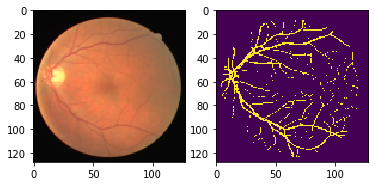

In [13]:
img,mask = dataset[0]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

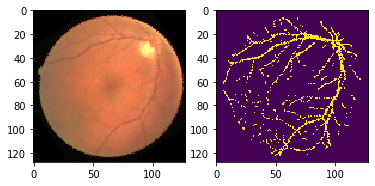

In [14]:
#Нарисуем картинку и идеальную для неё маск
img,mask = data_aug[3]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [15]:
#Разобьём датасет на валидацию
def train_test_split(data):
    train_data_new = []
    test_data_new = []
    len_data  = int(len(data) * 0.85) #длина обучающей выборки
    for i in range(len_data):
        train_data_new.append(data[i]) 
    
    for i in range(len(data)-len_data):
        test_data_new.append(data[len_data + i])
    
    random.shuffle(train_data_new) #перемешиваем обуч выборку
    random.shuffle(test_data_new) #перемешиваем тестовую выборку
    
    return train_data_new, test_data_new

train_data_new_aug, test_data_new_aug = train_test_split(data_aug)
train_data_new, test_data_new = train_test_split(dataset)
for tr in train_data_new:
    train_data_new_aug.append(tr)
for te in test_data_new:
    test_data_new_aug.append(te)

In [16]:
len(train_data_new_aug)

119

In [17]:
# sub-parts of the U-Net model
from torch import nn

import torch.nn.functional as F

###Две свертки###
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

###Внутри класса вызываем класс две свёртки))
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

###Идём вниз (уменьшаем размерность пулингом и  делаем две свертки)
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

###Поднимаемся вверх (грубо говоря востанавливаем картинку)
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super().__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

#Свертка
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1) 

    def forward(self, x):
        x = self.conv(x)
        return x

#Юнэт
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.nn.functional.sigmoid(x)
        return x

In [18]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [19]:
###класс Lossa
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [20]:
len(train_data_new)

17

In [21]:
network = UNet(3,1) #объявляем модель


train_dataloader = torch.utils.data.DataLoader(train_data_new,num_workers=2,batch_size=2)
test_dataloader = torch.utils.data.DataLoader(test_data_new,num_workers=2,batch_size=2)


device = "cpu"


if torch.cuda.is_available():
    device = "cuda"
criterion = DiceLoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 100

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)

evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(DiceLoss())}, device=device)

training_history = {'l2':[]}
validation_history = {'l2':[]}
last_epoch = []

In [22]:
x = []
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    validation_history['l2'].append(l2)
    
    x.append(int(len(training_history['l2']) -  1))
    clear_output(True)
    fig = go.Figure()
    fig.add_trace(go.Scatter( x = x, y = training_history['l2'], mode='lines+markers', name = "training_Loss"))
    fig.add_trace(go.Scatter( x = x, y = validation_history ['l2'], mode='lines+markers', name = "validation_Loss"))
    fig.update_layout(legend_orientation="h",
                  margin=dict(l=0, r=0, t=100, b=0),
                  hovermode="x",
                  xaxis_title="EPOCHS",
                  yaxis_title="LOSS",)
    fig.show()

In [23]:
trainer.run(train_dataloader, max_epochs=max_epochs)

Engine run is terminating due to exception: .


KeyboardInterrupt: 

In [24]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = torch.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = torch.utils.data.DataLoader(testset,batch_size = 1)

In [25]:
oo = []
datal = [] 
model = network.eval()
for ex_id, data in enumerate(testdataloader):
    data = torch.autograd.Variable(data, volatile=True)
    datal.append(data)
    o = model(data)
    oo.append(o)
    source_image = io.imread("Seminar 6//data//test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    print(source_image.shape[:-1])
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    imageio.imwrite("result3/%s.png" % (ex_id + 1), tm)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning:

volatile was removed and now has no effect. Use `with torch.no_grad():` instead.

C:\anaconda\lib\site-packages\skimage\external\tifffile\tifffile.py:2616: RuntimeWarning:

py_decodelzw encountered unexpected end of stream



(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(584, 565)


Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [269]:
oo[0][0].shape

torch.Size([1, 128, 128])

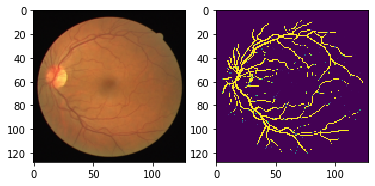

In [270]:
tm=oo[0][0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(datal[0][0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

In [271]:
data[0].shape

torch.Size([3, 128, 128])

In [272]:
oo[19].shape

torch.Size([1, 1, 128, 128])